In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
results = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/resampling/outputs/grid_searches/model_fine_tuning.csv', index_col=0)

In [3]:
for params, df in results.groupby(['param_max_depth', 'param_min_samples_leaf']):
    print(params)
    display(df[['mean_test_score', 'std_test_score']].mean())

(4, 1)


mean_test_score    0.254892
std_test_score     0.012338
dtype: float64

(4, 5)


mean_test_score    0.254841
std_test_score     0.012352
dtype: float64

(4, 10)


mean_test_score    0.254752
std_test_score     0.012331
dtype: float64

(50, 1)


mean_test_score    0.721762
std_test_score     0.015164
dtype: float64

(50, 5)


mean_test_score    0.680201
std_test_score     0.015701
dtype: float64

(50, 10)


mean_test_score    0.629612
std_test_score     0.015805
dtype: float64

(100, 1)


mean_test_score    0.721762
std_test_score     0.015164
dtype: float64

(100, 5)


mean_test_score    0.680201
std_test_score     0.015701
dtype: float64

(100, 10)


mean_test_score    0.629612
std_test_score     0.015805
dtype: float64

---

In [6]:
# #### THE FINAL CHOICE IS: max_depth': 50, 'min_samples_leaf': 1

rss = [516, 1919, 700]

X_train = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/final_X_train_val.csv', index_col=0)
y_train = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/y_train_val.csv')

regression_forest = dict()

for rs in rss:
    regression_forest[rs] = RandomForestRegressor(max_depth=50,
                                          min_samples_leaf=1,
                                          n_jobs=-1, 
                                          random_state=rs
                                          )

    regression_forest[rs].fit(X_train, y_train.iloc[:, 0])

In [7]:
with open('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target//resampling/src/trained_models/final_model.pkl', 'wb') as f:
    pickle.dump(regression_forest, f)

with open('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/resampling/src/trained_models/final_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [8]:
transform = {0.0:0,0.1:1,0.2:2,0.3:3,0.4:4,0.5:5,0.6:6,0.7:7,0.8:8,0.9:9,1.0:10}

scores = dict()

for rs in rss:
    y_train_pred = model[rs].predict(X_train).round(1)
    scores[rs] = (r2_score(y_train_pred, y_train), 
                  accuracy_score(pd.Series(y_train_pred).map(transform), pd.Series(y_train.iloc[:, 0]).map(transform)))

print(np.mean([v[0] for v in scores.values()]), np.mean([v[1] for v in scores.values()]))


X_test = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/final_X_test.csv', index_col=0)
y_test = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/y_test.csv')

scores = dict()

for rs in rss:
    y_test_pred = model[rs].predict(X_test).round(1)
    scores[rs] = (r2_score(y_test_pred, y_test), 
                  accuracy_score(pd.Series(y_test_pred).map(transform), pd.Series(y_test.iloc[:, 0]).map(transform)))

print(np.mean([v[0] for v in scores.values()]), np.mean([v[1] for v in scores.values()]))

0.9422820947144146 0.6820526744501766
0.52584988496517 0.34358974358974353


In [9]:
def predict_dispersion(crosstab):
    total = 0
    for i, row in enumerate(crosstab.to_numpy()):
        for j, val in enumerate(row):
            total += val * abs(j - i)
    return total/(crosstab.sum().sum())*(crosstab.shape[1])

In [10]:
train_mat= pd.crosstab(y_train.iloc[:, 0], y_train_pred)
test_mat = pd.crosstab(y_test.iloc[:,0], y_test_pred)

In [11]:
print(train_mat.shape)
print(test_mat.shape)

print(predict_dispersion(train_mat))
print(predict_dispersion(test_mat))

(11, 11)
(11, 11)
3.869761969408996
12.241025641025642


---

In [12]:
#### THE FINAL CHOICE IS: max_depth': 50, 'min_samples_leaf': 1

rss = [516, 1919, 700]

X_train = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/final_X_train_val.csv', index_col=0)
y_train = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/y_train_val.csv')

classification_forest = dict()

for rs in rss:
    classification_forest[rs] = RandomForestClassifier(max_depth=50,
                                          min_samples_leaf=1,
                                          n_jobs=-1, 
                                          random_state=rs
                                          )

    classification_forest[rs].fit(X_train, y_train.iloc[:, 0].map(transform))

with open('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/resampling/src/trained_models/final_classification_model.pkl', 'wb') as f:
    pickle.dump(classification_forest, f)

In [13]:
with open('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/resampling/src/trained_models/final_classification_model.pkl', 'rb') as f:
    model = pickle.load(f)

transform = {0.0:0,0.1:1,0.2:2,0.3:3,0.4:4,0.5:5,0.6:6,0.7:7,0.8:8,0.9:9,1.0:10}

scores = dict()

for rs in rss:
    y_train_pred = model[rs].predict(X_train).round(1)
    scores[rs] = (r2_score(y_train_pred, y_train.iloc[:, 0].map(transform)), 
                  accuracy_score(pd.Series(y_train_pred), pd.Series(y_train.iloc[:, 0]).map(transform)))

print(np.mean([v[0] for v in scores.values()]), np.mean([v[1] for v in scores.values()]))


X_test = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/final_X_test.csv', index_col=0)
y_test = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/y_test.csv')

scores = dict()

for rs in rss:
    y_test_pred = model[rs].predict(X_test).round(1)
    scores[rs] = (r2_score(y_test_pred, y_test.iloc[:, 0].map(transform)), 
                  accuracy_score(pd.Series(y_test_pred), pd.Series(y_test.iloc[:, 0]).map(transform)))

print(np.mean([v[0] for v in scores.values()]), np.mean([v[1] for v in scores.values()]))

0.9906396727975194 0.9924880079645216
0.6599579742669057 0.5194871794871795


In [14]:
train_mat= pd.crosstab(y_train.iloc[:,0], y_train_pred)
test_mat = pd.crosstab(y_test.iloc[:,0], y_test_pred)

In [15]:
print(train_mat.shape)
print(test_mat.shape)

print(predict_dispersion(train_mat))
print(predict_dispersion(test_mat))

(11, 11)
(11, 11)
0.23794008507557246
11.07897435897436


---

In [16]:
with open('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/resampling/src/trained_models/final_classification_model.pkl', 'rb') as f:
    classification_forest = pickle.load(f)

with open('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/resampling/src/trained_models/final_model.pkl', 'rb') as f:
    regression_forest = pickle.load(f)

In [17]:
y_train = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/y_train_val.csv')
y_test = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/y_test.csv')

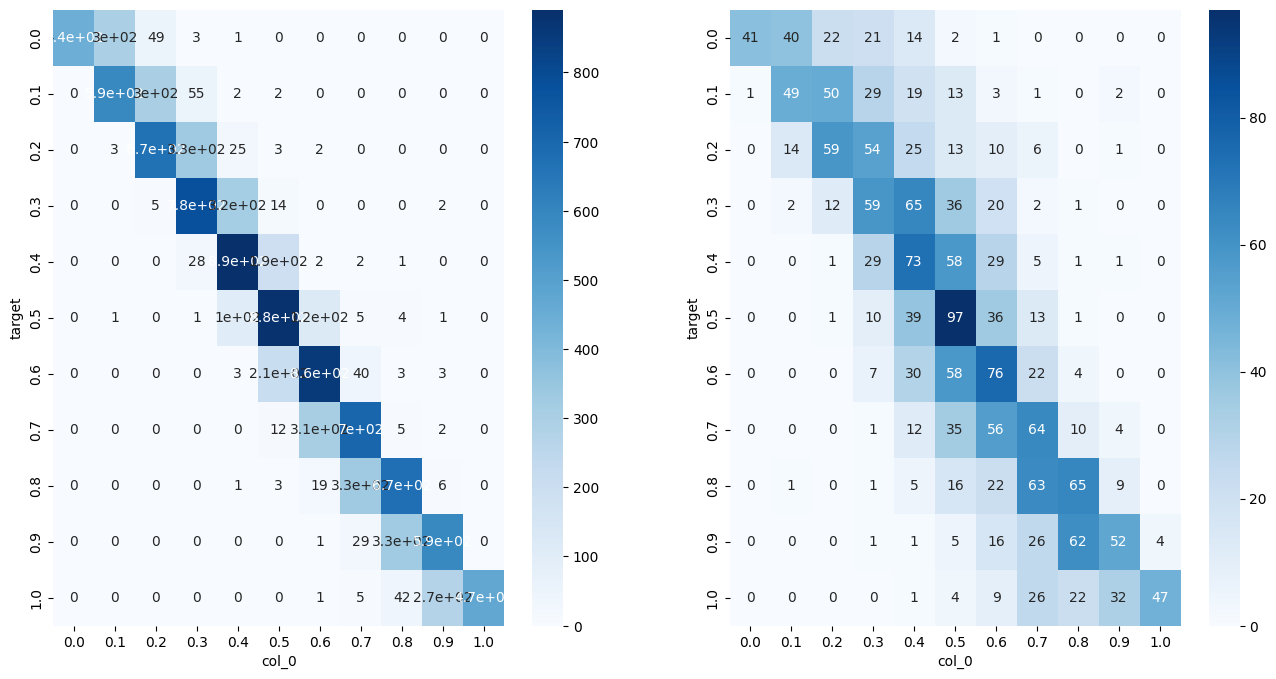

In [18]:
fig, ax = plt.subplots(1,2, figsize=(16, 8))

sns.heatmap(pd.crosstab(
                        y_train.iloc[:, 0], 
                        regression_forest[516].predict(X_train).round(1)
                        ),
                        cmap='Blues',
                        annot = True,
                        ax=ax[0]
                        )

sns.heatmap(pd.crosstab(
                        y_test.iloc[:, 0], 
                        regression_forest[516].predict(X_test).round(1)
                        ),
                        cmap='Blues',
                        annot = True,
                        ax=ax[1]
                        )

plt.show()

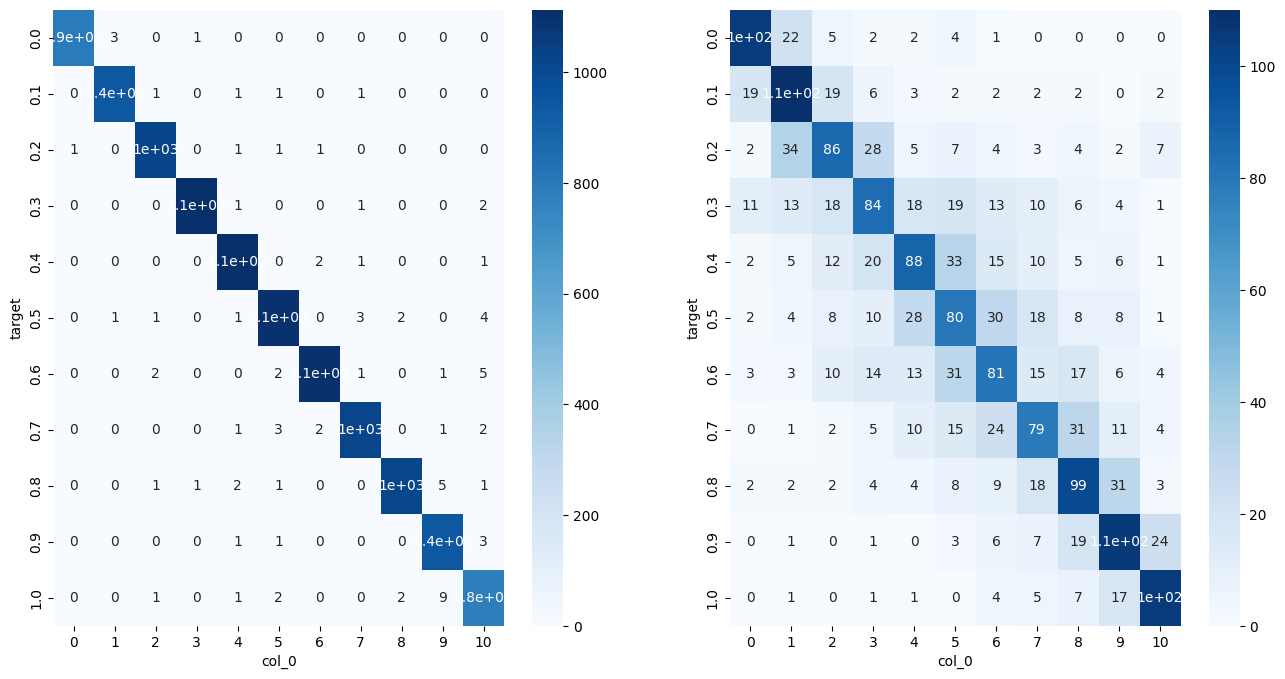

In [19]:
fig, ax = plt.subplots(1,2, figsize=(16, 8))

sns.heatmap(pd.crosstab(
                        y_train.iloc[:, 0], 
                        classification_forest[516].predict(X_train)
                        ),
                        cmap='Blues',
                        annot = True,
                        ax=ax[0]
                        )

sns.heatmap(pd.crosstab(
                        y_test.iloc[:, 0], 
                        classification_forest[516].predict(X_test)
                        ),
                        cmap='Blues',
                        annot = True,
                        ax=ax[1]
                        )

plt.show()